# PINN: Heat equation with variable diffusion
Solving the heat equation in 2D for variable diffusion D using the PINN-concept.

In [1]:
import urllib
print('TorchPhysics Tutorial')
url = 'https://torchphysics.readthedocs.io/en/latest/tutorial/tutorial_start.html'
print(url)

TorchPhysics Tutorial
https://torchphysics.readthedocs.io/en/latest/tutorial/tutorial_start.html


#### pde: ### 
$u_t(t,x) + D \cdot \Delta u(t,x) = 0\,, \quad x\in \Omega=[0,w]\times[0,h]\,, \
             \quad t \in [0,T]\,,\quad D\in [D_{min},D_{max}]$
#### BC + IC ####
$u(t,x)= T_m \sin(\pi/w x_1) \cdot \sin(\pi/h x_2)\,,  x=(x_1,x_2)\in \partial \Omega, \quad \text{and} \quad u(t=0,x)=0\,, x\in \Omega$

In [2]:
c
import time 

First, we create the spaces for our problem. These define the variable names which will be used in the remaining part of this code.

In this example, x is the space variable, t corresponds to the time, D is an interval of diffusions and u is the variable for the (1D-)solution.

In [3]:
# Input
X = tp.spaces.R2('x')
T = tp.spaces.R1('t')
D = tp.spaces.R1('D')
# Output
U = tp.spaces.R1('u')

As a next step, we build the domain of the problem. There are multiple options to build multi-dimensional domains - in this case, we simply create a rectangle in space and intervals in time and diffusion which will later be multiplied to obtain the cartesian product.

In [4]:
# Size of rectangular domain 
h, w = 10, 10
# Interval of heat diffusion coefficient D
Dmin, Dmax = 0.1 , 1.5
# Interval for time 
tstart, tend = 0, 10
# Maximal temperature 
Tm = 10

In [5]:
A_x = tp.domains.Parallelogram(X, [0, 0], [w, 0], [0, h])
A_t = tp.domains.Interval(T, tstart, tend)
A_D = tp.domains.Interval(D, Dmin, Dmax)

Before we visualize the created domain, we create Sampler objects which are iterators that sample points from the domain during the optimization task. There are various options to sample from the domains, an easy way would be to sample uniformly distributed random points. In this example, we choose a grid sampler and keep the sampled points static during the optimization.

The amount of sampled points could be increased to achieve better training results.

In [6]:
# total: 10*10*20*5 = 10000 static inner sampling points

inner_sampler = (tp.samplers.RandomUniformSampler(A_x, n_points = 10*10) \
                        *(tp.samplers.GridSampler(A_t, n_points = 20) \
                        *(tp.samplers.GridSampler(A_D, n_points = 5)))).make_static()
initial_v_sampler = (tp.samplers.GridSampler(A_x, n_points = 10*10) \
                        *(tp.samplers.GridSampler(A_t.boundary_left, n_points = 1) \
                        *(tp.samplers.GridSampler(A_D, n_points = 5)))).make_static()
boundary_v_sampler = (tp.samplers.GridSampler(A_x.boundary, n_points = 100) \
                        *(tp.samplers.GridSampler(A_t, n_points = 20) \
                        *(tp.samplers.GridSampler(A_D, n_points = 5)))).make_static()                      

We visualize the domain through the points created by the samplers using matplotlib:

C:\daten\Pytorch\_venv\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
C:\daten\Pytorch\_venv\lib\site-packages\torchphysics\problem\domains\domain2D\parallelogram.py:134: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2318.)
  bary_coords = torch.stack(torch.meshgrid((x, y))).T.reshape(-1, 2)


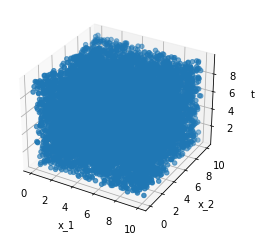

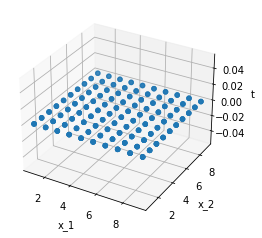

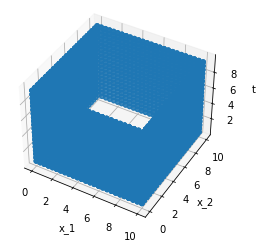

In [7]:
fig1=tp.utils.scatter(X*T, inner_sampler)
fig2=tp.utils.scatter(X*T, initial_v_sampler)
fig3=tp.utils.scatter(X*T, boundary_v_sampler)
fig3.axes[0].view_init(40)

In the next step we define the NN-model we want to fit to the PDE. A normalization can improve convergence for large or small domains.

In [8]:
# model with a normalization layer - in same cases it's application can be really useful to increase the convergence rate, but 
# there are also cases, where the layer does not lead to more benefit
model = tp.models.Sequential(
    tp.models.NormalizationLayer(A_x*A_t*A_D),
    tp.models.FCN(input_space=X*T*D, output_space=U, hidden=(20,20)))
  

# model without the normalization layer
# model = tp.models.FCN(input_space=X*T*D, output_space=U, hidden=(30,30,30))


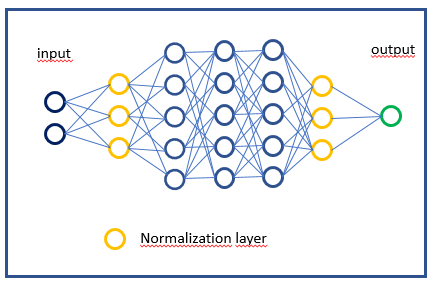

In [9]:
from IPython.display import Image
Image('NN.png',width=200, height=150)

Now, we define a condition which aims to minimze the mean squared error of the residual of the heat equation. 

In [10]:
def heat_residual(u, x, t, D):
    return D*tp.utils.laplacian(u, x) - tp.utils.grad(u, t)

pde_condition = tp.conditions.PINNCondition(module=model,
                                            sampler=inner_sampler,
                                            residual_fn=heat_residual,
                                            name='pde_condition')

Additionally, we add a boundary condition at the boundary of the domain:

In [11]:
def boundary_v_residual(u):
    return u

boundary_v_condition = tp.conditions.PINNCondition(module=model,
                                                     sampler=boundary_v_sampler,
                                                     residual_fn=boundary_v_residual,
                                                     name='boundary_condition')

The initial condition can be defined via a data function. Again, we minimize the mean squared error over the sampled points.

In [12]:
def f(x):
    return Tm*torch.sin(math.pi/w*x[:, :1])*torch.sin(math.pi/h*x[:,1:])

def initial_v_residual(u, f):
    return u-f

initial_v_condition = tp.conditions.PINNCondition(module=model,
                                                  sampler=initial_v_sampler,
                                                  residual_fn=initial_v_residual,
                                                  data_functions={'f': f},
                                                  name='initial_condition')

Finally, we optimize the conditions using a pytorch-lightning.LightningModule Solver and running the training. In the Solver, the training and validation conditions, as well as all optimizer options can be specified.

In [13]:
opt_setting = tp.solver.OptimizerSetting(torch.optim.AdamW, lr=1e-2) #AdamW, SGD, LBFGS
solver = tp.solver.Solver([pde_condition,
                           boundary_v_condition,
                           initial_v_condition], optimizer_setting = opt_setting)

start = time.time()
trainer = pl.Trainer(gpus=None, # or 1 if GPU available
                     max_steps = 200,
                     #logger=False, 
                     benchmark=True,
                     log_every_n_steps=1,
                     enable_checkpointing=False)
trainer.fit(solver)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 561   
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
561       Trainable params
0         Non-trainable params
561       Total params
0.002     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\daten\Pytorch\_venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\daten\Pytorch\_venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [14]:
opt_setting = tp.solver.OptimizerSetting(torch.optim.LBFGS, lr=1e-2)

solver = tp.solver.Solver([pde_condition,
                           boundary_v_condition,
                           initial_v_condition], optimizer_setting = opt_setting)


trainer = pl.Trainer(gpus=None, # or 1 if GPU available
                     max_steps=200,  #500  with normalization layer
                     #logger=False,
                     benchmark=True,
                     log_every_n_steps=1,                     
                     enable_checkpointing=False)
trainer.fit(solver)
end = time.time()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 561   
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
561       Trainable params
0         Non-trainable params
561       Total params
0.002     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [15]:
print('Training time : ',(end-start)/60., 'min')

Training time :  2.3934639573097227 min


Finally, we plot the obtained solution as animation over the time

C:\daten\Pytorch\_venv\lib\site-packages\torchphysics\utils\plotting\plot_functions.py:401: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:210.)
  embed_point = Points(torch.tensor([center]), domain.space)


<IPython.core.display.Javascript object>


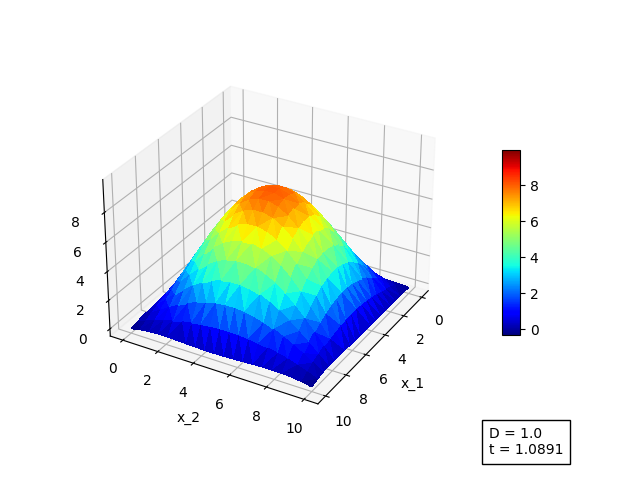

MovieWriter ffmpeg unavailable; using Pillow instead.


HDE_stat1.0.gif
---- Fertig ----


In [16]:
%matplotlib notebook
D_val = 1.0
anim_sampler = tp.samplers.AnimationSampler(A_x, A_t, 100, n_points=400, data_for_other_variables={'D': D_val})
anim = tp.utils.animate(model, lambda u: u[:, 0], anim_sampler, ani_speed=5)

name = 'HDE_stat'+str(D_val)+'.gif'
print(name)
anim[1].save(name)
print('---- Fertig ----')

Here we plot maximal and minimal temperature of the PINN-solution as function of time 

tensor(1.5057, grad_fn=<UnbindBackward0>)
tensor(-0.3011, grad_fn=<UnbindBackward0>)


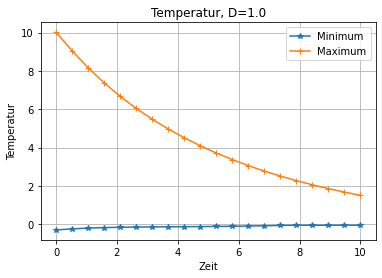

In [17]:
D_value = 1.0
time_steps = 20

grid_sampler = tp.samplers.GridSampler(A_x, n_points=128*128) + tp.samplers.GridSampler(A_x.boundary, n_points=1000)
grid_points = grid_sampler.sample_points()
D_tensor = D_value * torch.ones((len(grid_points), 1))
time_points = torch.linspace(0, tend, time_steps)
min_max_tensor = torch.zeros((time_steps, 2))

for i in range(time_steps):
    time_tensor = time_points[i] * torch.ones((len(grid_points), 1))
    eval_points = grid_points.join(tp.spaces.Points.from_coordinates({'t': time_tensor,
                                                                      'D': D_tensor}))
    model_out = model(eval_points)
    min_max_tensor[i, 0] = torch.min(model_out)
    min_max_tensor[i, 1] = torch.max(model_out)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(time_points, min_max_tensor[:, 0].detach().numpy(), marker='*')
plt.plot(time_points, min_max_tensor[:, 1].detach().numpy(), marker='+')
plt.legend(['Minimum', 'Maximum'])
plt.title('Temperatur, D=' + str(D_value))
plt.grid()
plt.xlabel('Zeit')
plt.ylabel('Temperatur')
#plt.savefig('HDE_static_Tmaxmin.png', dvi = 600)

print(min(min_max_tensor[:,1]))
print(min(min_max_tensor[:,0]))


Finally, we compare our PINN-solution against a solution computed via finite differences. For a set of randomly sampled diffusion coefficients the relative L2-error of PINN vs. FDM-solution is computed and plotted against the diffusion.

Maximal L2 error:    15.026 %


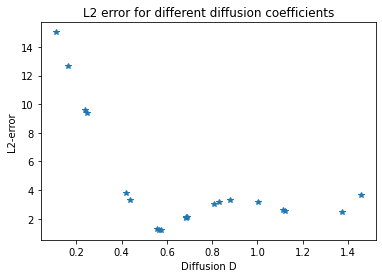

In [18]:
import sys
sys.path.append('../..')

from fdm_heat_equation import FDM, transform_to_points

D_values=tp.samplers.RandomUniformSampler(A_D,20).sample_points().as_tensor.numpy().reshape(-1)
import numpy as np
error_norm_l2_list = []
for Dval in D_values:
    fdm_domain, fdm_time_domains, fdm_solution = FDM([0, w, 0, h], 2*[2e-1], [0,tend], [Dval], f)
    fdm_inp, fdm_out = transform_to_points(fdm_domain, fdm_time_domains, fdm_solution, [Dval], True)
    model_out_vec = model(fdm_inp)
    error_val=100*torch.linalg.norm(fdm_out-model_out_vec)/torch.linalg.norm(fdm_out)
    error_norm_l2_list.append(error_val.detach().numpy())

plt.plot(D_values,error_norm_l2_list,'*')
plt.title('L2 error for different diffusion coefficients')
plt.xlabel('Diffusion D')
plt.ylabel('L2-error')
print('Maximal L2 error: ',"%8.3f" %np.max(error_norm_l2_list),'%')